In [1]:
save = True

In [2]:
#import packages
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from statannot import add_stat_annotation

In [3]:
# import from other scripts
import plot_utils
import stats_utils

In [4]:
model_identifier = "gpt2-xl"
outdir = os.path.abspath(os.path.join(os.getcwd(), 'results_paper_revision/robustness'))
if not os.path.exists(outdir):
    os.makedirs(outdir, exist_ok=True)

# get score frames

In [5]:
CAT2COND, COND2CAT = plot_utils.get_conditions()

In [6]:
frames = []
for testonperturbed in [True, False]:
    for emb_context in ["Passage", "Sentence"]:
        condition_name1 = "TrainIntact-TestPerturbed" if testonperturbed else "TrainPerturbed-TestPerturbed"
        condition_name2 = "contextualized" if emb_context == "Passage" else "decontextualized"
        condition_name = f"{condition_name1}:{condition_name2}"
        print(condition_name)
        curr_df = plot_utils.get_best_scores_df(model_identifier, emb_context=emb_context, split_coord="Sentence", testonperturbed=testonperturbed,
                                               which_df = 'plot')
        # average errors for original
        for cond in ['original', 'random-wl']:
            scores = curr_df.loc[curr_df['condition'] == cond]['score']
            errors = curr_df.loc[curr_df['condition'] == cond]['error']
            score = np.mean(scores)
            error = np.mean(errors)
            
            #delete duplicate rows
            curr_df = curr_df[curr_df.condition != cond]
            
            # create a new row to insert at the first index
            new_row = pd.Series({'score': score, 'error': error, 'condition': cond, 'category': COND2CAT[cond],
                                'category_group' : 'all'})

            if cond == 'original':
                # insert the new row at the first index
                curr_df.loc[-1] = new_row
                curr_df.index = curr_df.index + 1
                curr_df = curr_df.sort_index()
            else:
                # insert the new row at the last index
                curr_df.loc[len(curr_df)] = new_row

        curr_df["score_conditions"] = [condition_name] * len(curr_df)
        frames.append(curr_df)
full_df = pd.concat(frames)

TrainIntact-TestPerturbed:contextualized
{'word-order': ['teston:original', 'teston:scr1', 'teston:scr3', 'teston:scr5', 'teston:scr7', 'teston:backward', 'teston:lowpmi', 'teston:lowpmi-random', 'teston:random-wl'], 'information-loss': ['teston:original', 'teston:contentwords', 'teston:nounsverbsadj', 'teston:nounsverbs', 'teston:nouns', 'teston:functionwords', 'teston:random-wl'], 'semantic-distance': ['teston:original', 'teston:chatgpt', 'teston:sentenceshuffle_passage', 'teston:sentenceshuffle_topic', 'teston:sentenceshuffle_random', 'teston:random-wl']}
TrainIntact-TestPerturbed:decontextualized
{'word-order': ['teston:original', 'teston:scr1', 'teston:scr3', 'teston:scr5', 'teston:scr7', 'teston:backward', 'teston:lowpmi', 'teston:lowpmi-random', 'teston:random-wl'], 'information-loss': ['teston:original', 'teston:contentwords', 'teston:nounsverbsadj', 'teston:nounsverbs', 'teston:nouns', 'teston:functionwords', 'teston:random-wl'], 'semantic-distance': ['teston:original', 'testo

In [7]:
full_df

,score,error,condition,category,category_group,score_conditions
0,0.352717,0.018506,original,original,all,TrainIntact-TestPerturbed:contextualized
2,0.324739,0.018587,scrambled1,word-order,word-order,TrainIntact-TestPerturbed:contextualized
3,0.294472,0.014565,scrambled3,word-order,word-order,TrainIntact-TestPerturbed:contextualized
4,0.289114,0.011329,scrambled5,word-order,word-order,TrainIntact-TestPerturbed:contextualized
5,0.291322,0.016302,scrambled7,word-order,word-order,TrainIntact-TestPerturbed:contextualized
...,...,...,...,...,...,...
18,0.254555,0.037491,chatgpt,semantic-distance,semantic-distance,TrainPerturbed-TestPerturbed:decontextualized
19,0.209784,0.023178,sent_passage,semantic-distance,semantic-distance,TrainPerturbed-TestPerturbed:decontextualized
20,0.068925,0.028132,sent_topic,semantic-distance,semantic-distance,TrainPerturbed-TestPerturbed:decontextualized
21,0.023347,0.028225,sent_random,semantic-distance,semantic-distance,TrainPerturbed-TestPerturbed:decontextualized


In [8]:
full_df.loc[full_df["category"]=="original"]

,score,error,condition,category,category_group,score_conditions
0,0.352717,0.018506,original,original,all,TrainIntact-TestPerturbed:contextualized
0,0.262723,0.023009,original,original,all,TrainIntact-TestPerturbed:decontextualized
0,0.352717,0.016309,original,original,all,TrainPerturbed-TestPerturbed:contextualized
0,0.262592,0.023456,original,original,all,TrainPerturbed-TestPerturbed:decontextualized


# Plot

In [9]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }

sns.set_theme(font_scale=2.5, style="white", rc=custom_params)

In [10]:
#Rename conditions according to new names:
full_df['condition'] = full_df['condition'].map(plot_utils.COND2LABEL)
full_df['condition'] = full_df['condition'].replace(
        {'RandSentFromPassage': 'RandSent\nFromPassage',
         'RandSentFromTopic': 'RandSent\nFromTopic',
         'ParaphraseChatGPT': 'Paraphrase\nChatGPT'})

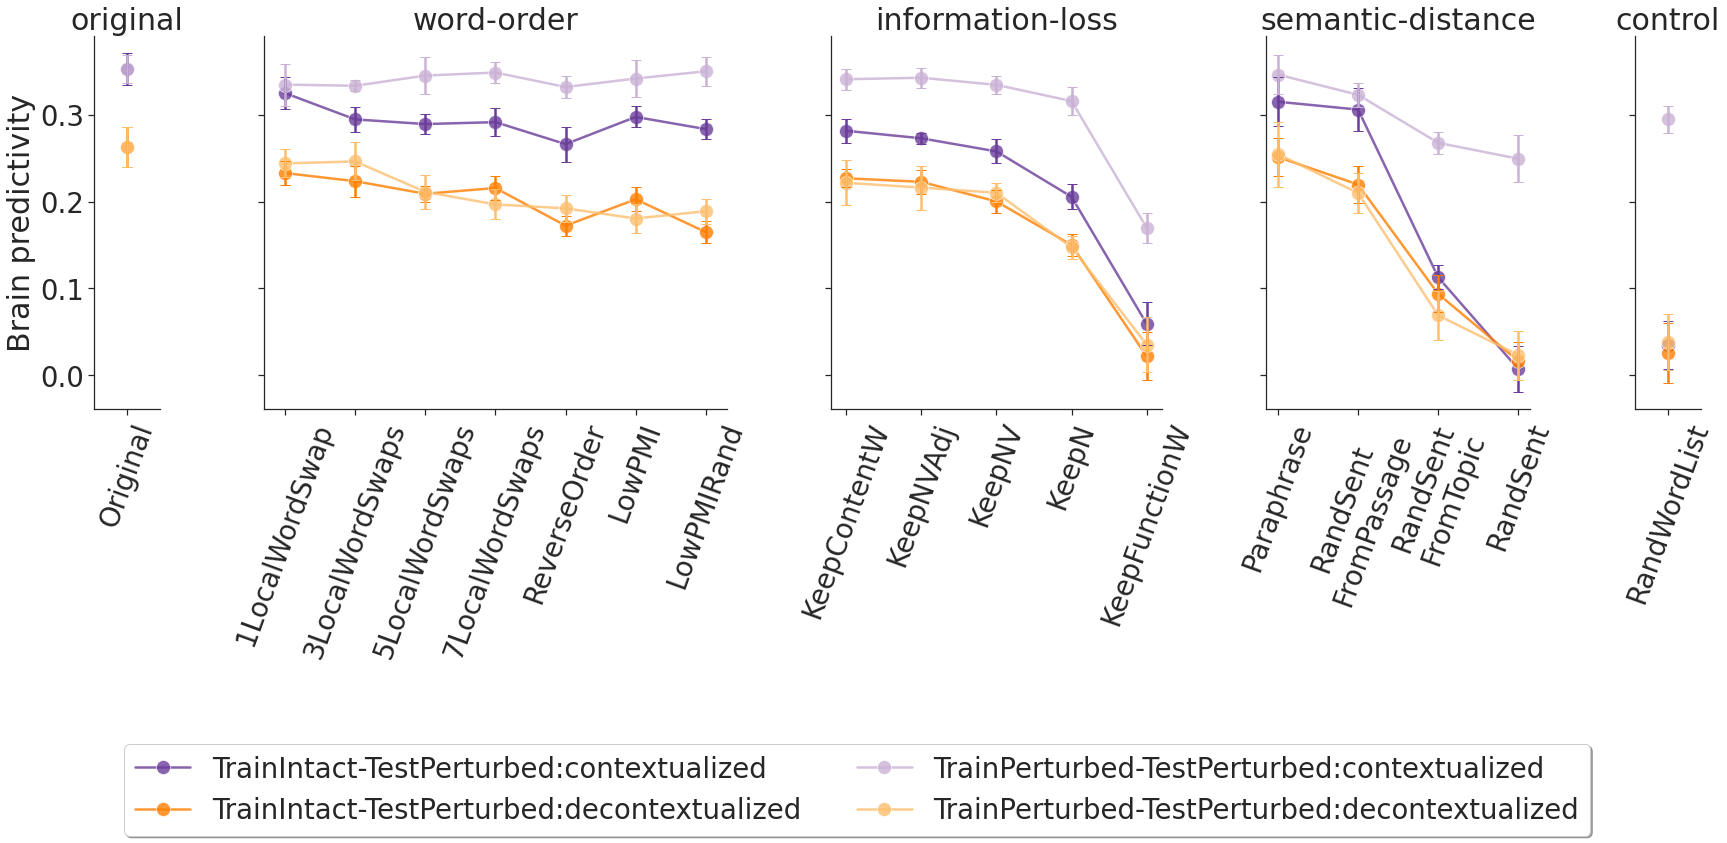

In [11]:
#get proportions for subplot width
categories = CAT2COND.keys()
props = [len(full_df.loc[full_df["category"] == cat])/len(full_df) for cat in categories]

palette = [sns.color_palette('Paired')[9], sns.color_palette('Paired')[7],
           sns.color_palette('Paired')[8], sns.color_palette('Paired')[6],
          sns.color_palette("Set2")[0]]

g = sns.FacetGrid(full_df, col="category", sharex=False, hue="score_conditions",
                  gridspec_kws={"width_ratios": props},
                  height=10, aspect=0.5, palette=palette)

g.map(sns.lineplot, "condition", "score", alpha=0.8, markersize=14, marker="o", linewidth=2.5)
g.map(plt.errorbar, "condition", "score", "error", capsize=5, linewidth=2.5, ls='none')
g.set_xlabels("")
g.set_ylabels("Brain predictivity")
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=70)
score_conditions = list(full_df["score_conditions"].unique())
# Put a legend below current axis
g.fig.legend(loc='upper center', labels=score_conditions,
          bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)

g.fig.tight_layout()

if save:
    plt.savefig(f'{outdir}/lineplot.svg', dpi=180, bbox_inches='tight')
    plt.savefig(f'{outdir}/lineplot.png', dpi=180, bbox_inches='tight')

plt.show()

# Stats

In [12]:
stats_frames = []
for testonperturbed in [True, False]:
    for emb_context in ["Passage", "Sentence"]:
        condition_name1 = "TrainIntact-TestPerturbed" if testonperturbed else "TrainPerturbed-TestPerturbed"
        condition_name2 = "contextualized" if emb_context == "Passage" else "decontextualized"
        condition_name = f"{condition_name1}:{condition_name2}"
        print(condition_name)
        curr_stats_df = plot_utils.get_best_scores_df(model_identifier, emb_context=emb_context,
                                                      split_coord="Sentence", testonperturbed=testonperturbed,
                                                       which_df = 'stats')
        curr_stats_df["score_conditions"] = [condition_name] * len(curr_stats_df)
        stats_frames.append(curr_stats_df)
full_stats_df = pd.concat(stats_frames).reset_index(drop=True)

TrainIntact-TestPerturbed:contextualized
{'word-order': ['teston:original', 'teston:scr1', 'teston:scr3', 'teston:scr5', 'teston:scr7', 'teston:backward', 'teston:lowpmi', 'teston:lowpmi-random', 'teston:random-wl'], 'information-loss': ['teston:original', 'teston:contentwords', 'teston:nounsverbsadj', 'teston:nounsverbs', 'teston:nouns', 'teston:functionwords', 'teston:random-wl'], 'semantic-distance': ['teston:original', 'teston:chatgpt', 'teston:sentenceshuffle_passage', 'teston:sentenceshuffle_topic', 'teston:sentenceshuffle_random', 'teston:random-wl']}
TrainIntact-TestPerturbed:decontextualized
{'word-order': ['teston:original', 'teston:scr1', 'teston:scr3', 'teston:scr5', 'teston:scr7', 'teston:backward', 'teston:lowpmi', 'teston:lowpmi-random', 'teston:random-wl'], 'information-loss': ['teston:original', 'teston:contentwords', 'teston:nounsverbsadj', 'teston:nounsverbs', 'teston:nouns', 'teston:functionwords', 'teston:random-wl'], 'semantic-distance': ['teston:original', 'testo

In [13]:
full_stats_df

,values,subject_index,condition,category,category_group,score_conditions
0,0.311779,018,original,original,word-order,TrainIntact-TestPerturbed:contextualized
1,0.292175,199,original,original,word-order,TrainIntact-TestPerturbed:contextualized
2,0.308316,215,original,original,word-order,TrainIntact-TestPerturbed:contextualized
3,0.339043,288,original,original,word-order,TrainIntact-TestPerturbed:contextualized
4,0.357018,289,original,original,word-order,TrainIntact-TestPerturbed:contextualized
...,...,...,...,...,...,...
875,0.070267,296,random-wl,control,semantic-distance,TrainPerturbed-TestPerturbed:decontextualized
876,-0.008173,343,random-wl,control,semantic-distance,TrainPerturbed-TestPerturbed:decontextualized
877,-0.024310,366,random-wl,control,semantic-distance,TrainPerturbed-TestPerturbed:decontextualized
878,0.039635,407,random-wl,control,semantic-distance,TrainPerturbed-TestPerturbed:decontextualized


In [14]:
def func(string):
    return "_".join(string.split(":"))

full_stats_df['score_conditions'] = full_stats_df['score_conditions'].apply(func)

In [15]:
# Plot arguments
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.55, 0.04, 0.3]}

In [16]:
# # correlation across all 17 conditions (170 datapoints because every condition has 10 subject scores)

# import scikit_posthocs as sp

# CAT2COND, COND2CAT = plot_utils.get_conditions()
# score_conditions = list(full_stats_df['score_conditions'])

# ttest = sp.posthoc_ttest(full_stats_df, val_col='values', group_col='score_conditions', p_adjust='fdr_bh')
# plt.figure(figsize=(10,10))
# sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
# plt.subplots_adjust(top=0.8) 

# ttest_df = pd.DataFrame(ttest)
# ttest_df.to_csv(f'{outdir}/stats_robustness_overall.csv')

# plt.savefig(f'{outdir}/stats_robustness_overall.svg', dpi=180)
# plt.savefig(f'{outdir}/stats_robustness_overall.png', dpi=180, bbox_inches='tight')

# plt.show()

In [17]:
# get correlation values
from scipy import stats
score_conditions = np.unique(list(full_stats_df['score_conditions']))
combinations = [(elm1, elm2) for elm1 in score_conditions for elm2 in score_conditions]

corr_stats_df = full_stats_df.copy(deep=True)
print(len(corr_stats_df))
#dropping multiple occurrences of "original" and "random-wl"
corr_stats_df = corr_stats_df.drop(columns=["category_group"])
corr_stats_df = corr_stats_df.drop_duplicates()
print(len(corr_stats_df))
elms1, elms2, rs, ps = [],[],[],[]
for (elm1, elm2) in combinations:
    values1 = list(full_stats_df.loc[full_stats_df["score_conditions"] == elm1]["values"])
    values2 = list(full_stats_df.loc[full_stats_df["score_conditions"] == elm2]["values"])
    res = stats.pearsonr(values1,values2)
    print(f"{elm1} | {elm2} | {res}")
    elms1.append(elm1)
    elms2.append(elm2)
    rs.append(round(res[0],3))
    ps.append(round(res[1],3))
correlation_stats_df = pd.DataFrame({
    "Condition 1" : elms1,
    "Condition 2" : elms2,
    "Pearson r value" : rs,
    "p value" : ps
})

if save:
    correlation_stats_df.to_csv(f'{outdir}/pairwise_correlations_robustness.csv', index=False)

880
720
TrainIntact-TestPerturbed_contextualized | TrainIntact-TestPerturbed_contextualized | (0.9999999999999998, 0.0)
TrainIntact-TestPerturbed_contextualized | TrainIntact-TestPerturbed_decontextualized | (0.9425477095618494, 9.009035354291603e-106)
TrainIntact-TestPerturbed_contextualized | TrainPerturbed-TestPerturbed_contextualized | (0.6328997198171457, 5.03609542851082e-26)
TrainIntact-TestPerturbed_contextualized | TrainPerturbed-TestPerturbed_decontextualized | (0.932866897202568, 1.2422674067738235e-98)
TrainIntact-TestPerturbed_decontextualized | TrainIntact-TestPerturbed_contextualized | (0.9425477095618494, 9.009035354291603e-106)
TrainIntact-TestPerturbed_decontextualized | TrainIntact-TestPerturbed_decontextualized | (1.0, 0.0)
TrainIntact-TestPerturbed_decontextualized | TrainPerturbed-TestPerturbed_contextualized | (0.6250800259736228, 3.0054197449121974e-25)
TrainIntact-TestPerturbed_decontextualized | TrainPerturbed-TestPerturbed_decontextualized | (0.95615466244680

In [18]:
print(f'Average: {np.mean(rs)} | {np.mean(ps)}')

Average: 0.8435 | 0.0


In [19]:
for (elm1, elm2) in combinations:
    avg_values1 = np.mean(list(full_stats_df.loc[full_stats_df["score_conditions"] == elm1]["values"]))
    avg_values2 = np.mean(list(full_stats_df.loc[full_stats_df["score_conditions"] == elm2]["values"]))
    difference = avg_values1 - avg_values2
    print(f"{elm1} | {elm2} | {difference}")

TrainIntact-TestPerturbed_contextualized | TrainIntact-TestPerturbed_contextualized | 0.0
TrainIntact-TestPerturbed_contextualized | TrainIntact-TestPerturbed_decontextualized | 0.0663892920946749
TrainIntact-TestPerturbed_contextualized | TrainPerturbed-TestPerturbed_contextualized | -0.0903364938936953
TrainIntact-TestPerturbed_contextualized | TrainPerturbed-TestPerturbed_decontextualized | 0.06258455343036826
TrainIntact-TestPerturbed_decontextualized | TrainIntact-TestPerturbed_contextualized | -0.0663892920946749
TrainIntact-TestPerturbed_decontextualized | TrainIntact-TestPerturbed_decontextualized | 0.0
TrainIntact-TestPerturbed_decontextualized | TrainPerturbed-TestPerturbed_contextualized | -0.1567257859883702
TrainIntact-TestPerturbed_decontextualized | TrainPerturbed-TestPerturbed_decontextualized | -0.0038047386643066394
TrainPerturbed-TestPerturbed_contextualized | TrainIntact-TestPerturbed_contextualized | 0.0903364938936953
TrainPerturbed-TestPerturbed_contextualized | 

# Do same within category

In [20]:
# import scikit_posthocs as sp

# CAT2COND, COND2CAT = plot_utils.get_conditions()
# score_conditions = list(full_stats_df['score_conditions'])

# for category in CAT2COND.keys():
#     print(category)
#     sub_df = full_stats_df.loc[full_stats_df["category"] == category]
#     if category in ["original", "control"]:
#         sub_df = sub_df.drop(columns=["category_group"])
#         sub_df = sub_df.drop_duplicates()
#     print(len(sub_df))
#     ttest = sp.posthoc_ttest(sub_df, val_col='values', group_col='score_conditions', p_adjust='bonferroni')
        
#     plt.figure(figsize=(10,10))
#     sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
#     plt.subplots_adjust(top=0.8) 
#     plt.title(f'{category}')
    
#     ttest_df = pd.DataFrame(ttest)
#     ttest_df["manipulation"] = [f"{category}"] * len(ttest_df)
# #     ttest_df.to_csv(f'{outdir}/stats_robustness_{category}.csv')
    
# #     plt.savefig(f'{outdir}/stats_robustness_{category}.svg', dpi=180, bbox_inches='tight')
# #     plt.savefig(f'{outdir}/stats_robustness_{category}.png', dpi=180, bbox_inches='tight')

#     plt.show()


In [21]:
import scipy
from tqdm import tqdm
import statsmodels

CAT2COND, COND2CAT = plot_utils.get_conditions()
score_conditions = list(full_stats_df['score_conditions'].unique())

with_ttest_frames = []

for category in CAT2COND.keys():
    
    already_tested = [] #list to keep track of which combos were already tested (for correct number of multiple comparisons)
    # NOTE: only done for half of the comparisons, i.e., upper triangle of comparison matrix
    # https://github.com/maximtrp/scikit-posthocs/blob/master/scikit_posthocs/_posthocs.py#L1653
    
    ttests, pvals = [], []
    compare1, compare2 = [], []
    cohens_d = []
    
    subdf = full_stats_df.loc[full_stats_df["category"] == category]
    if category in ["original", "control"]:
        subdf = subdf.drop(columns=["category_group"])
        subdf = subdf.drop_duplicates()
    print(f"{category} | {len(subdf)} | {len(subdf['values'].unique())}")
    
    for sc1 in score_conditions:
        sc1_scores = list(subdf[subdf['score_conditions'] == sc1]["values"])
        
        for sc2 in score_conditions:
            
            if sc1 == sc2:
                continue
            
            if set([sc1, sc2]) in already_tested:
                # print(f"Already tested the comparison {sc1} & {sc2}")
                continue
            else:
                sc2_scores = list(subdf[subdf['score_conditions'] == sc2]["values"])

                #get ttest
                ttest, pval = scipy.stats.ttest_rel(sc1_scores, sc2_scores)
                #get cohens d
                cohensd = stats_utils.cohens_d(sc1_scores, sc2_scores)

                ttests.append(round(ttest,3))
                pvals.append(pval)
                compare1.append(sc1)
                compare2.append(sc2)
                cohens_d.append(cohensd)

                already_tested.append(set([sc1, sc2]))
    
    # _, adjusted_pvals = statsmodels.stats.multitest.fdrcorrection(pvals) #NOL SUBMISSION
    _, adjusted_pvals, _, _ = statsmodels.stats.multitest.multipletests(pvals, method='bonferroni')
    adjusted_pvals = [round(x,3) for x in adjusted_pvals]
    significances = stats_utils.assign_significance_labels(adjusted_pvals)
    
    adjusted_pvals = [round(x,3) for x in adjusted_pvals]
    pvals = [round(x,3) for x in pvals]
    cohens_d = [round(x,3) for x in cohens_d]
    significances = stats_utils.assign_significance_labels(adjusted_pvals) 
    
    ttest_df = pd.DataFrame({
        "Experimental Design 1" : compare1,
        "Experimental Design 2" : compare2,
        "T-test statistic" : ttests,
        "Adjusted pvalue" : adjusted_pvals,
        "Significance" : significances,
        "Cohen's d" : cohens_d,
        "Unadjusted p value" : pvals
    })
    ttest_df["Manipulation"] = category
    #print(ttest_df)
    ttest_df.to_csv(f'{outdir}/stats_robustness_{category}_withttest.csv', index=False)
    
    with_ttest_frames.append(ttest_df)
    
combined_with_ttest_frame = pd.concat(with_ttest_frames)

if save:
    combined_with_ttest_frame.to_csv(f'{outdir}/stats_robustness_withttest_ALL.csv', index=False)

original | 40 | 30
word-order | 280 | 280
information-loss | 200 | 200
semantic-distance | 160 | 160
control | 40 | 40


In [22]:
combined_with_ttest_frame

,Experimental Design 1,Experimental Design 2,T-test statistic,Adjusted pvalue,Significance,Cohen's d,Unadjusted p value,Manipulation
0,TrainIntact-TestPerturbed_contextualized,TrainIntact-TestPerturbed_decontextualized,12.761,0.000,***,2.724,0.000,original
1,TrainIntact-TestPerturbed_contextualized,TrainPerturbed-TestPerturbed_contextualized,NaN,NaN,n.s.,0.000,NaN,original
2,TrainIntact-TestPerturbed_contextualized,TrainPerturbed-TestPerturbed_decontextualized,12.779,0.000,***,2.725,0.000,original
3,TrainIntact-TestPerturbed_decontextualized,TrainPerturbed-TestPerturbed_contextualized,-12.761,0.000,***,-2.724,0.000,original
4,TrainIntact-TestPerturbed_decontextualized,TrainPerturbed-TestPerturbed_decontextualized,1.710,0.728,n.s.,0.001,0.121,original
5,TrainPerturbed-TestPerturbed_contextualized,TrainPerturbed-TestPerturbed_decontextualized,12.779,0.000,***,2.725,0.000,original
0,TrainIntact-TestPerturbed_contextualized,TrainIntact-TestPerturbed_decontextualized,24.965,0.000,***,2.600,0.000,word-order
1,TrainIntact-TestPerturbed_contextualized,TrainPerturbed-TestPerturbed_contextualized,-11.522,0.000,***,-1.203,0.000,word-order
2,TrainIntact-TestPerturbed_contextualized,TrainPerturbed-TestPerturbed_decontextualized,21.512,0.000,***,2.441,0.000,word-order
3,TrainIntact-TestPerturbed_decontextualized,TrainPerturbed-TestPerturbed_contextualized,-26.873,0.000,***,-3.547,0.000,word-order


## Stats within condition manipulation for each factor analysis

In [23]:
def adjust_name(cond):
    #adjust names for consistency
    if cond == 'sentenceshuffle_random':
        cond = 'sent_random'
    elif cond == 'sentenceshuffle_passage':
        cond = 'sent_passage'
    elif cond == 'sentenceshuffle_topic':
        cond = 'sent_topic'
    return cond

In [24]:
def get_within_cond_stats(model_identifier="gpt2-xl", emb_context="Passage", split_coord="Sentence",
                testonperturbed=False, randomnouns=False):
    frames = []
    for category in ["word-order", "information-loss", "semantic-distance"]:
        stats_df = stats_utils.get_ttest_results(model_identifier=model_identifier,
                          emb_context=emb_context,
                          split_coord=split_coord,
                          testonperturbed=testonperturbed,
                          category=category, randomnouns=randomnouns)
        frames.append(stats_df)
    within_cond_stats_df = pd.concat(frames)
    return within_cond_stats_df

In [25]:
frames = []
for testonperturbed in [True, False]:
    for emb_context in ["Passage", "Sentence"]:
        condition_name1 = "TrainIntact-TestPerturbed" if testonperturbed else "TrainPerturbed-TestPerturbed"
        condition_name2 = "contextualized" if emb_context == "Passage" else "decontextualized"
        condition_name = f"{condition_name1}:{condition_name2}"
        print(condition_name)
        curr_df = get_within_cond_stats(model_identifier, emb_context=emb_context, split_coord="Sentence", testonperturbed=testonperturbed)
        curr_df["score_conditions"] = condition_name
        frames.append(curr_df)
full_within_stats_df = pd.concat(frames)

TrainIntact-TestPerturbed:contextualized
{'word-order': ['teston:original', 'teston:scr1', 'teston:scr3', 'teston:scr5', 'teston:scr7', 'teston:backward', 'teston:lowpmi', 'teston:lowpmi-random', 'teston:random-wl'], 'information-loss': ['teston:original', 'teston:contentwords', 'teston:nounsverbsadj', 'teston:nounsverbs', 'teston:nouns', 'teston:functionwords', 'teston:random-wl'], 'semantic-distance': ['teston:original', 'teston:chatgpt', 'teston:sentenceshuffle_passage', 'teston:sentenceshuffle_topic', 'teston:sentenceshuffle_random', 'teston:random-wl']}
{'word-order': ['teston:original', 'teston:scr1', 'teston:scr3', 'teston:scr5', 'teston:scr7', 'teston:backward', 'teston:lowpmi', 'teston:lowpmi-random', 'teston:random-wl'], 'information-loss': ['teston:original', 'teston:contentwords', 'teston:nounsverbsadj', 'teston:nounsverbs', 'teston:nouns', 'teston:functionwords', 'teston:random-wl'], 'semantic-distance': ['teston:original', 'teston:chatgpt', 'teston:sentenceshuffle_passage

In [26]:
full_within_stats_df.head()

,condition,ttest2original,ttest2random,adjusted_pvals2original,adjusted_pvals2random,cohensd2original,cohensd2random,significance2original,significance2random,pvals2original,pvals2random,score_conditions
0,scrambled1,5.516605,-18.326904,0.002605,1.371444e-07,0.571672,-8.288052,**,***,0.000372,1.959206e-08,TrainIntact-TestPerturbed:contextualized
1,scrambled3,5.814307,-17.437331,0.001784,2.122332e-07,1.527273,-9.486557,**,***,0.000255,3.031903e-08,TrainIntact-TestPerturbed:contextualized
2,scrambled5,6.506588,-17.103954,0.000774,2.513360e-07,1.629851,-9.322215,***,***,0.000111,3.590515e-08,TrainIntact-TestPerturbed:contextualized
3,scrambled7,6.781450,-16.789871,0.000565,2.955935e-07,1.640556,-9.229584,***,***,0.000081,4.222765e-08,TrainIntact-TestPerturbed:contextualized
4,backward,9.284902,-15.265252,0.000046,6.780925e-07,2.383474,-8.060254,***,***,0.000007,9.687036e-08,TrainIntact-TestPerturbed:contextualized


In [27]:
full_within_stats_df

,condition,ttest2original,ttest2random,adjusted_pvals2original,adjusted_pvals2random,cohensd2original,cohensd2random,significance2original,significance2random,pvals2original,pvals2random,score_conditions
0,scrambled1,5.516605,-18.326904,2.604779e-03,1.371444e-07,0.571672,-8.288052,**,***,3.721113e-04,1.959206e-08,TrainIntact-TestPerturbed:contextualized
1,scrambled3,5.814307,-17.437331,1.784078e-03,2.122332e-07,1.527273,-9.486557,**,***,2.548683e-04,3.031903e-08,TrainIntact-TestPerturbed:contextualized
2,scrambled5,6.506588,-17.103954,7.742035e-04,2.513360e-07,1.629851,-9.322215,***,***,1.106005e-04,3.590515e-08,TrainIntact-TestPerturbed:contextualized
3,scrambled7,6.781450,-16.789871,5.650804e-04,2.955935e-07,1.640556,-9.229584,***,***,8.072578e-05,4.222765e-08,TrainIntact-TestPerturbed:contextualized
4,backward,9.284902,-15.265252,4.628364e-05,6.780925e-07,2.383474,-8.060254,***,***,6.611949e-06,9.687036e-08,TrainIntact-TestPerturbed:contextualized
...,...,...,...,...,...,...,...,...,...,...,...,...
4,functionwords,17.135549,-0.543545,1.766479e-07,1.000000e+00,7.357444,-0.206388,***,n.s.,3.532959e-08,5.999575e-01,TrainPerturbed-TestPerturbed:decontextualized
0,chatgpt,0.825192,-13.161644,1.000000e+00,1.396755e-06,0.134657,-5.739535,n.s.,***,4.305912e-01,3.491887e-07,TrainPerturbed-TestPerturbed:decontextualized
1,sent_passage,6.790775,-10.023185,3.195224e-04,1.403965e-05,1.323913,-4.916004,***,***,7.988060e-05,3.509911e-06,TrainPerturbed-TestPerturbed:decontextualized
2,sent_topic,14.423591,-2.039976,6.338754e-07,2.870717e-01,5.997648,-1.078043,***,n.s.,1.584688e-07,7.176793e-02,TrainPerturbed-TestPerturbed:decontextualized


In [28]:
import re
score_conditions = [re.sub('_', ':', elm) for elm in score_conditions]
score_conditions

['TrainIntact-TestPerturbed:contextualized',
 'TrainIntact-TestPerturbed:decontextualized',
 'TrainPerturbed-TestPerturbed:contextualized',
 'TrainPerturbed-TestPerturbed:decontextualized']

In [29]:
for sc in score_conditions:
    sub_df = full_within_stats_df.loc[full_within_stats_df["score_conditions"]==sc]
    print(sub_df[['condition', 'significance2original', 'ttest2original', 'adjusted_pvals2original', 'cohensd2original']])
    print(sub_df[['condition', 'significance2random', 'ttest2random', 'adjusted_pvals2random', 'cohensd2random']])
    print("\n\n")

       condition significance2original  ttest2original  \
0     scrambled1                    **        5.516605   
1     scrambled3                    **        5.814307   
2     scrambled5                   ***        6.506588   
3     scrambled7                   ***        6.781450   
4       backward                   ***        9.284902   
5         lowpmi                   ***        6.354275   
6  lowpmi-random                   ***        8.467018   
0   contentwords                   ***        9.209139   
1  nounsverbsadj                   ***       12.824717   
2     nounsverbs                   ***       17.943714   
3          nouns                   ***       28.582549   
4  functionwords                   ***       17.400438   
0        chatgpt                   ***       10.781532   
1   sent_passage                   ***        6.843132   
2     sent_topic                   ***       28.347308   
3    sent_random                   ***       24.261823   

   adjusted_p

TrainIntact-TestPerturbed_contextualized
word-order
['scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'backward', 'lowpmi', 'lowpmi-random']


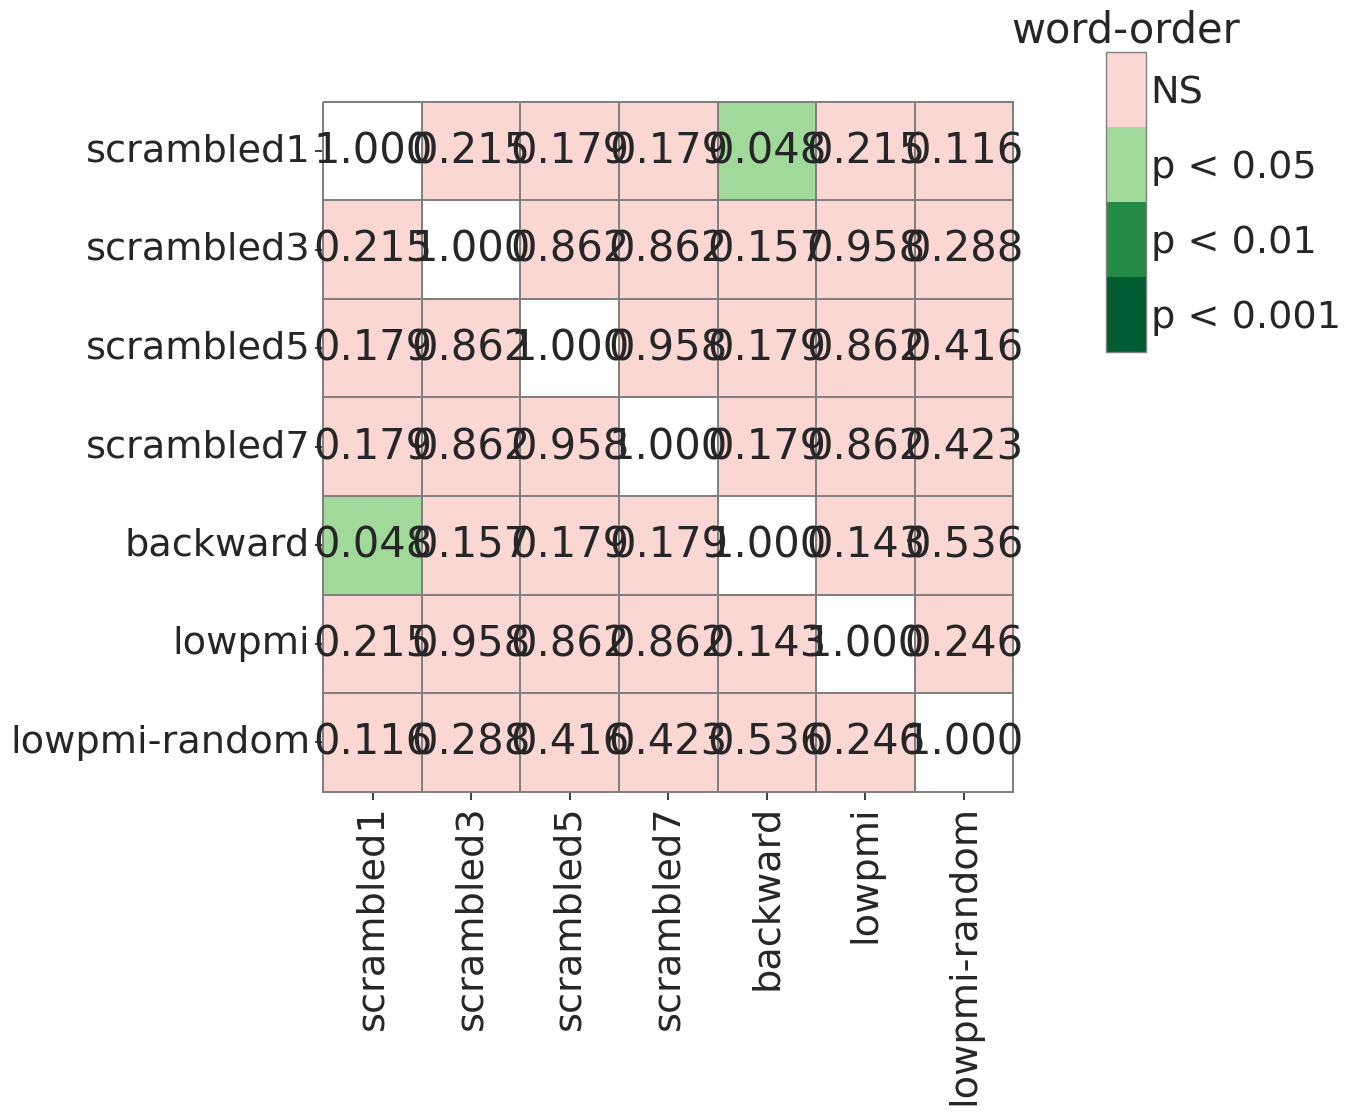

information-loss
['contentwords', 'nounsverbsadj', 'nounsverbs', 'nouns', 'functionwords']


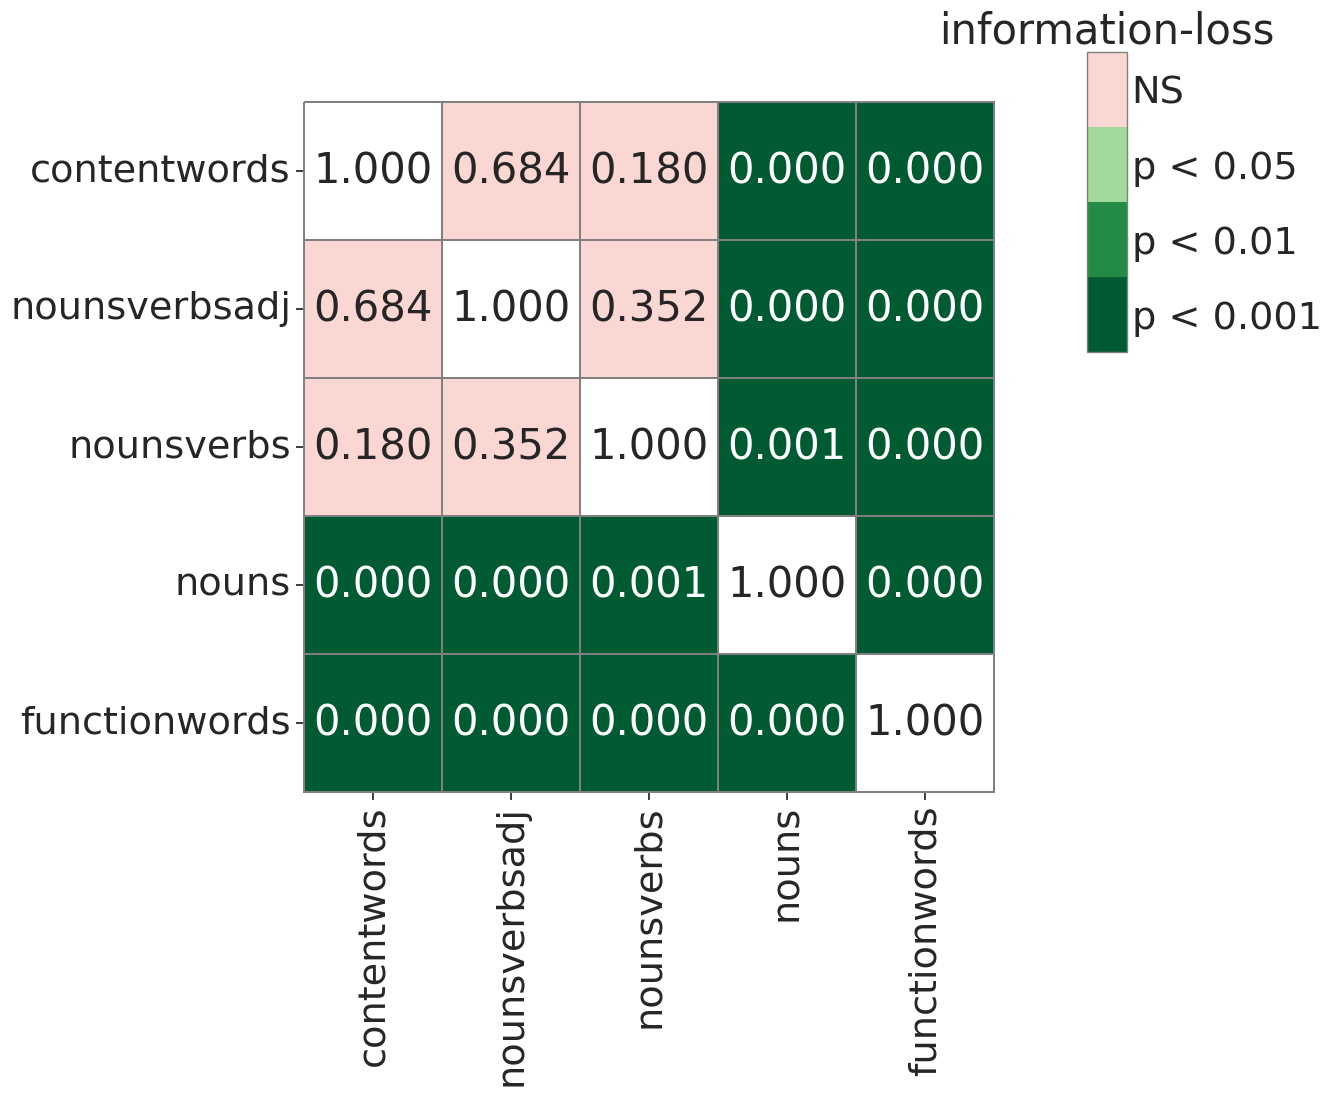

semantic-distance
['chatgpt', 'sent_passage', 'sent_topic', 'sent_random']


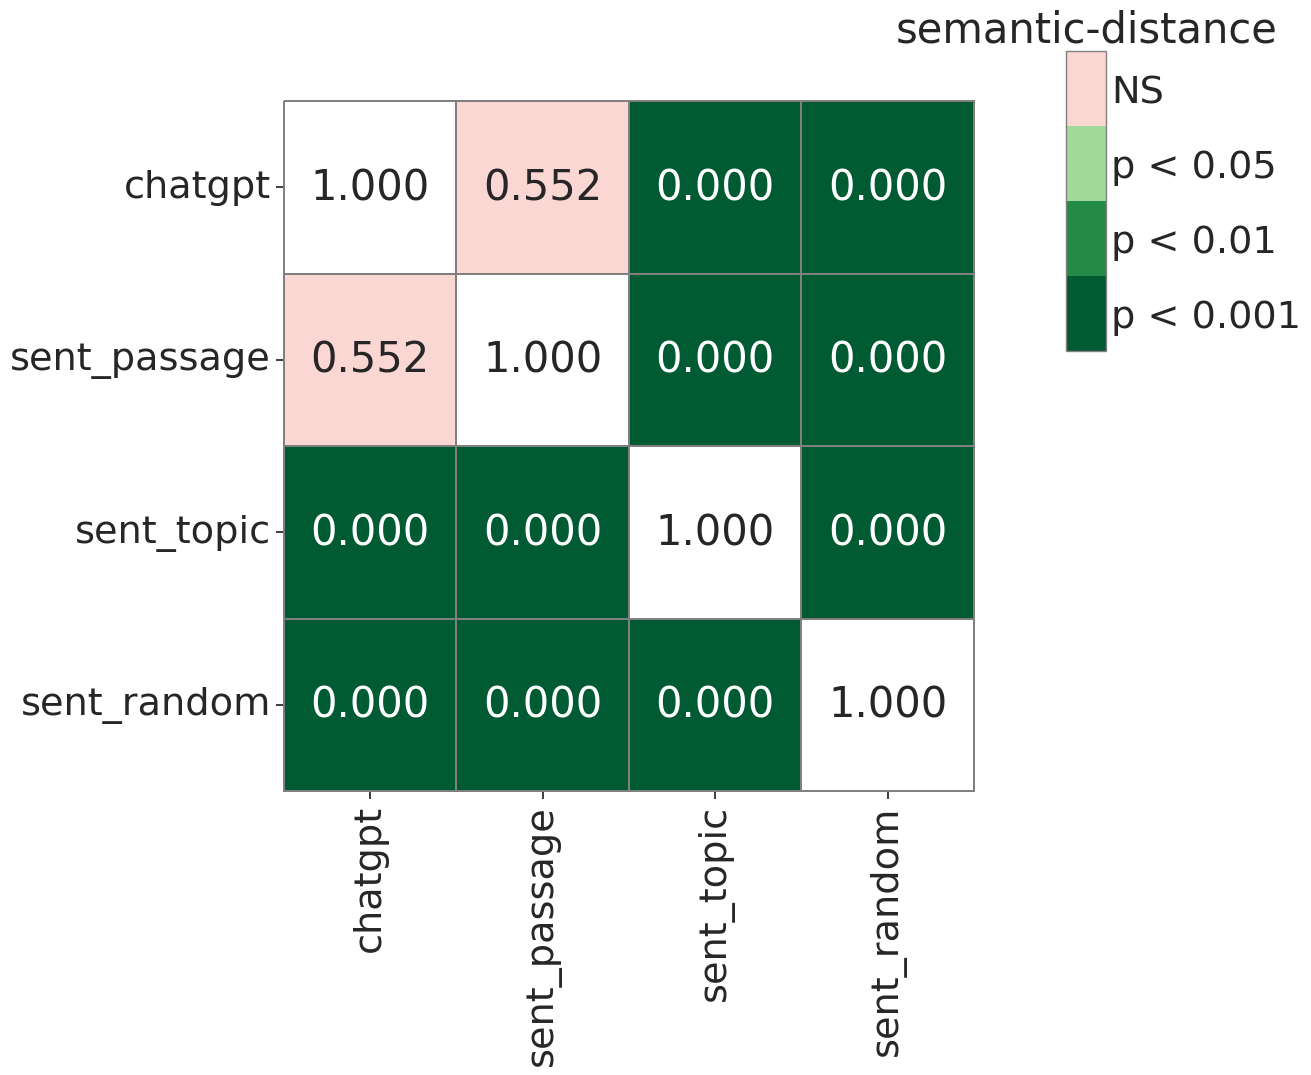

TrainIntact-TestPerturbed_decontextualized
word-order
['scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'backward', 'lowpmi', 'lowpmi-random']


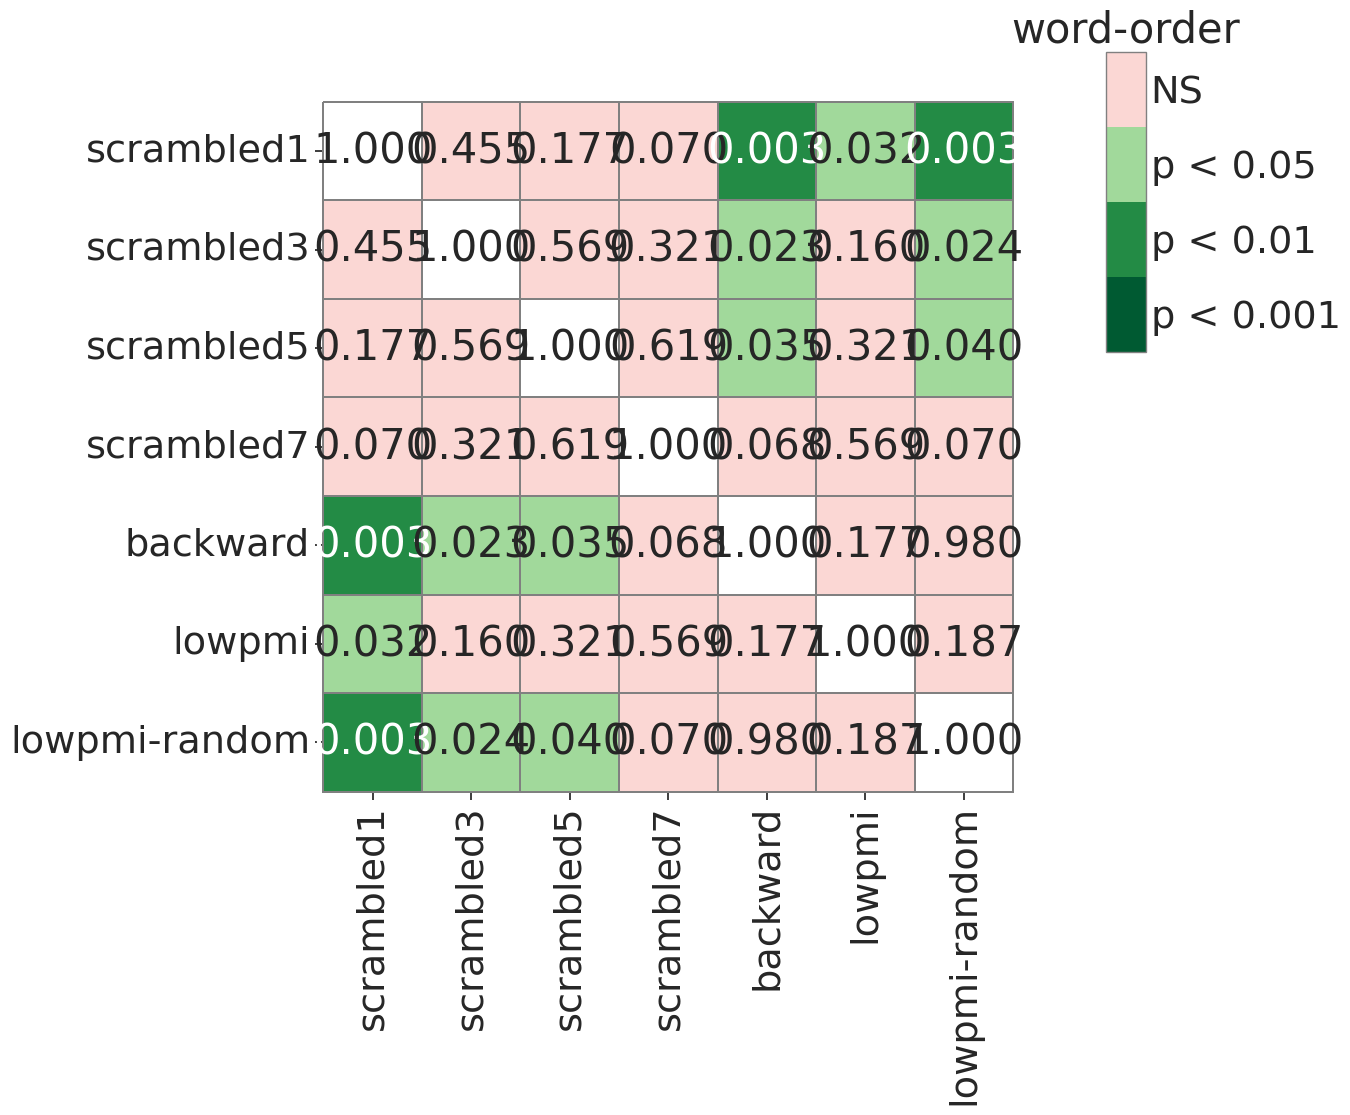

information-loss
['contentwords', 'nounsverbsadj', 'nounsverbs', 'nouns', 'functionwords']


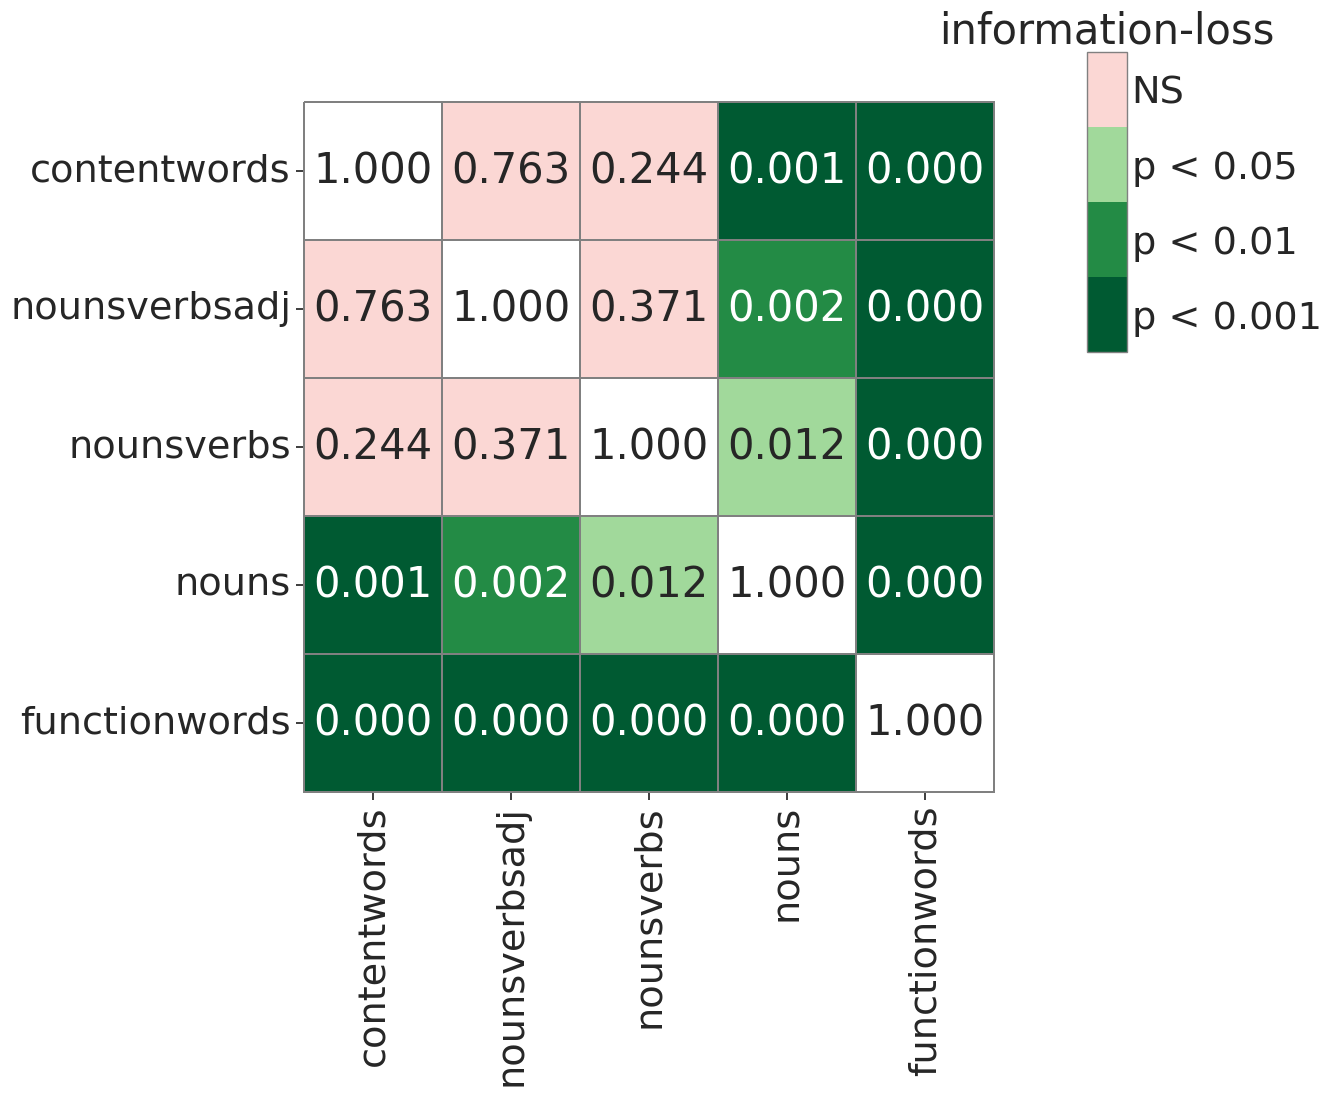

semantic-distance
['chatgpt', 'sent_passage', 'sent_topic', 'sent_random']


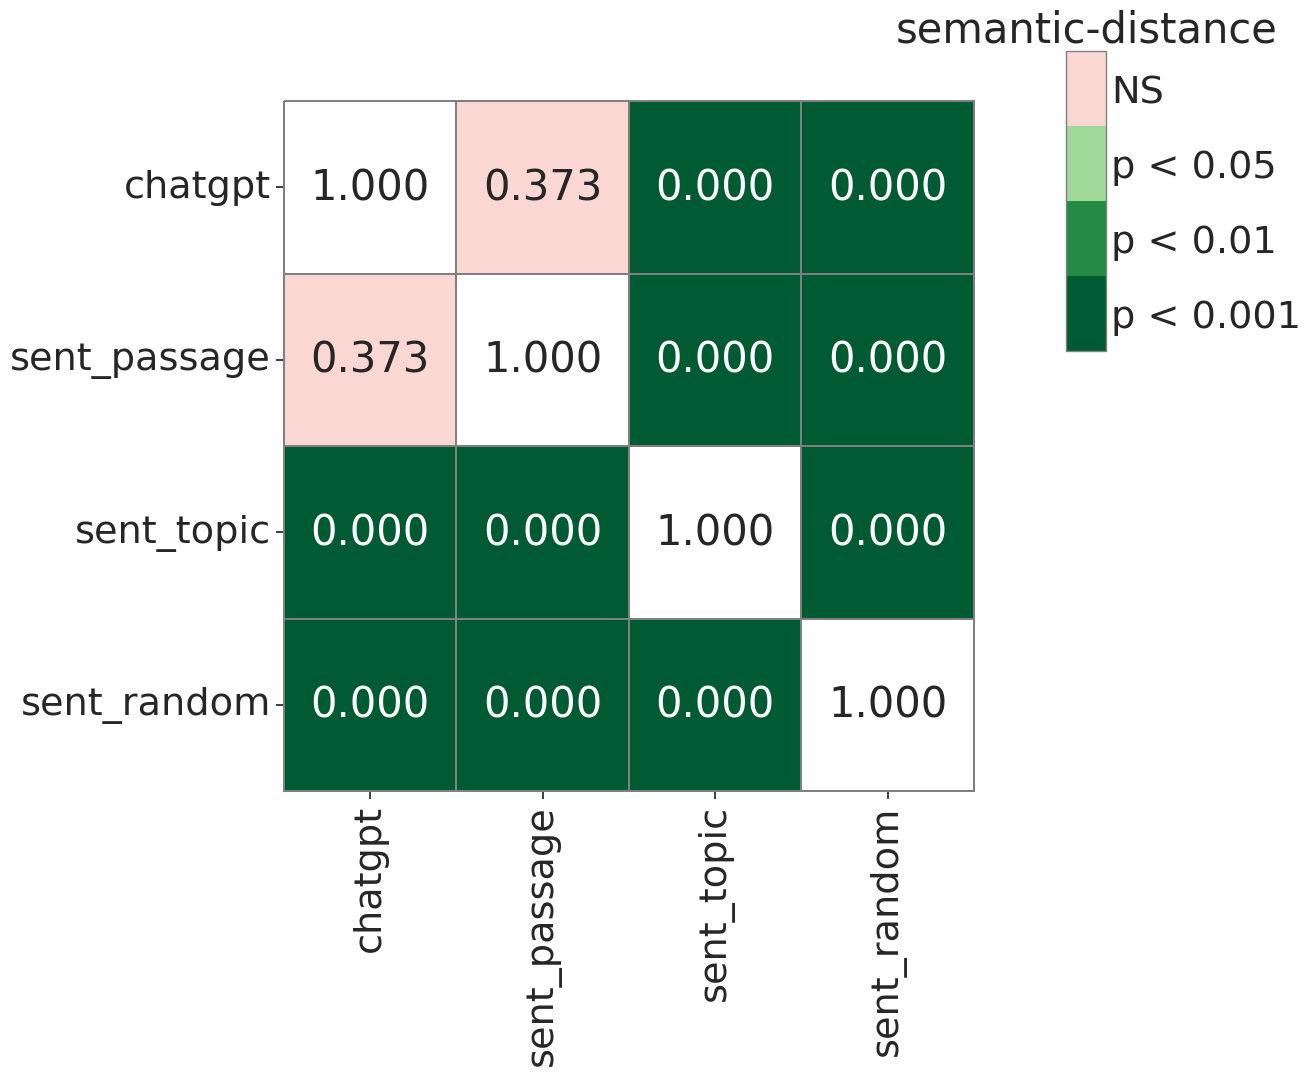

TrainPerturbed-TestPerturbed_contextualized
word-order
['scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'backward', 'lowpmi', 'lowpmi-random']


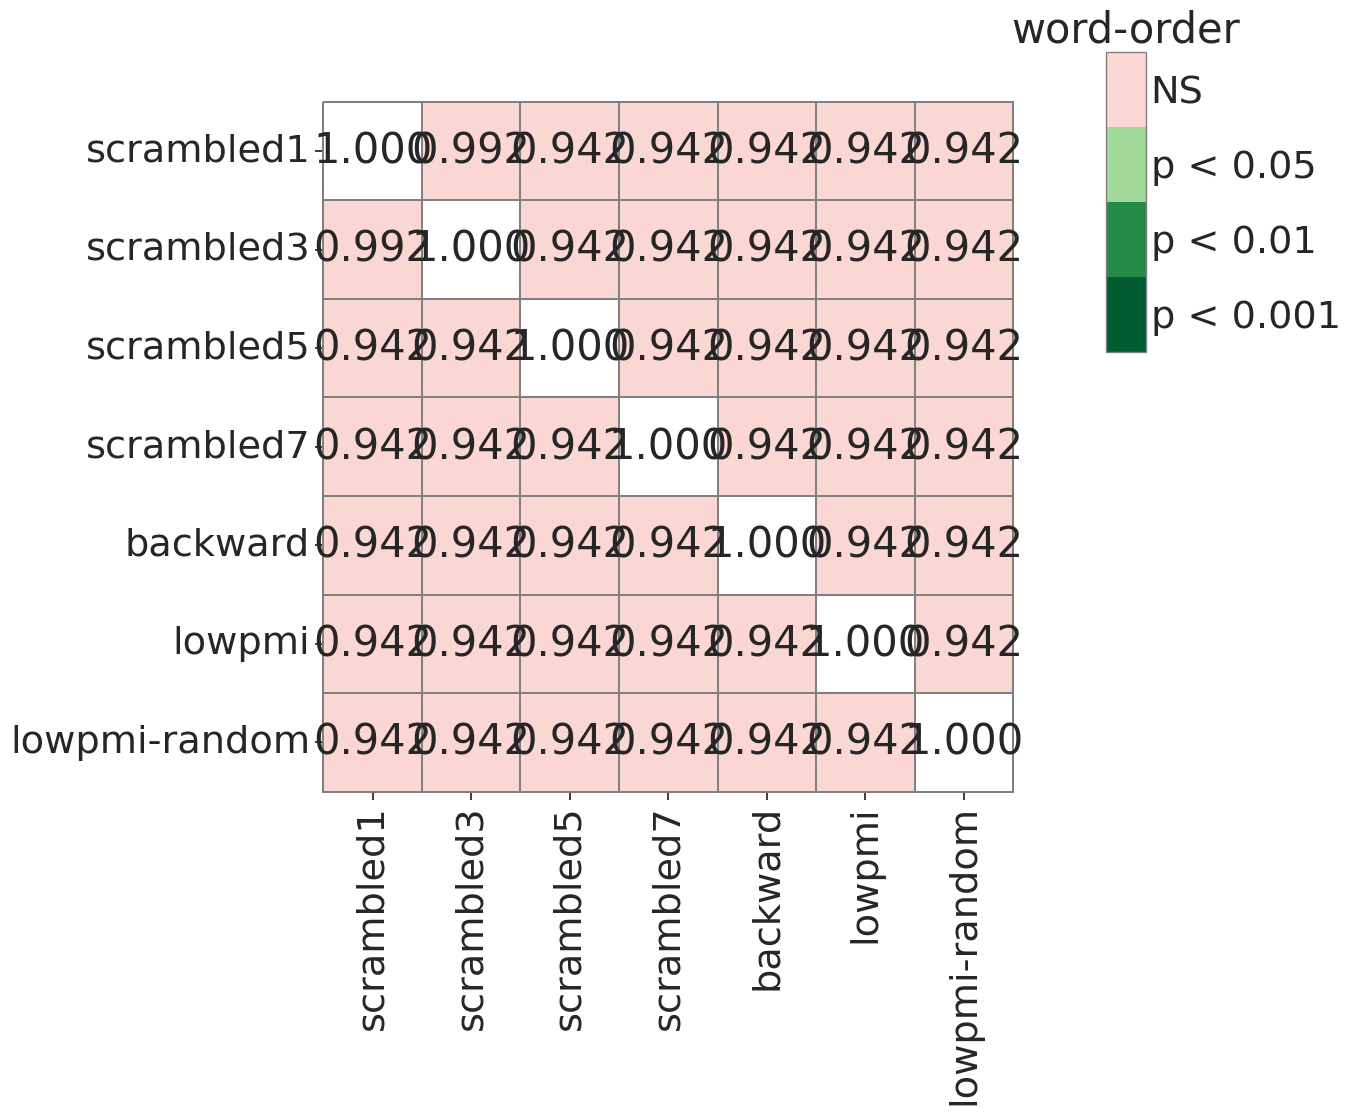

information-loss
['contentwords', 'nounsverbsadj', 'nounsverbs', 'nouns', 'functionwords']


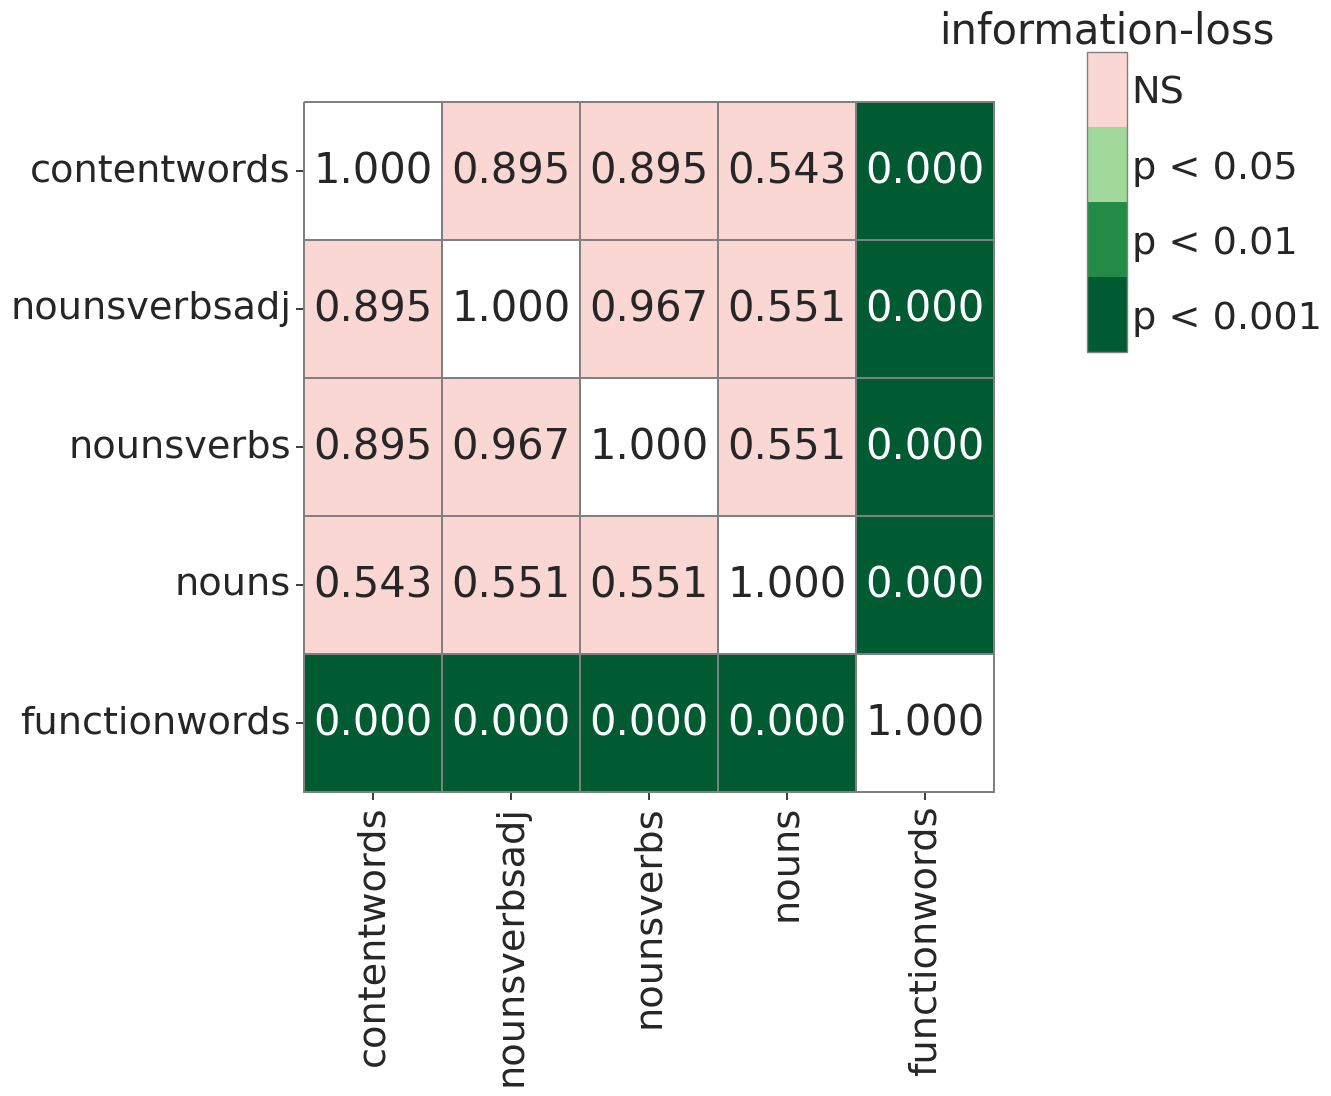

semantic-distance
['chatgpt', 'sent_passage', 'sent_topic', 'sent_random']


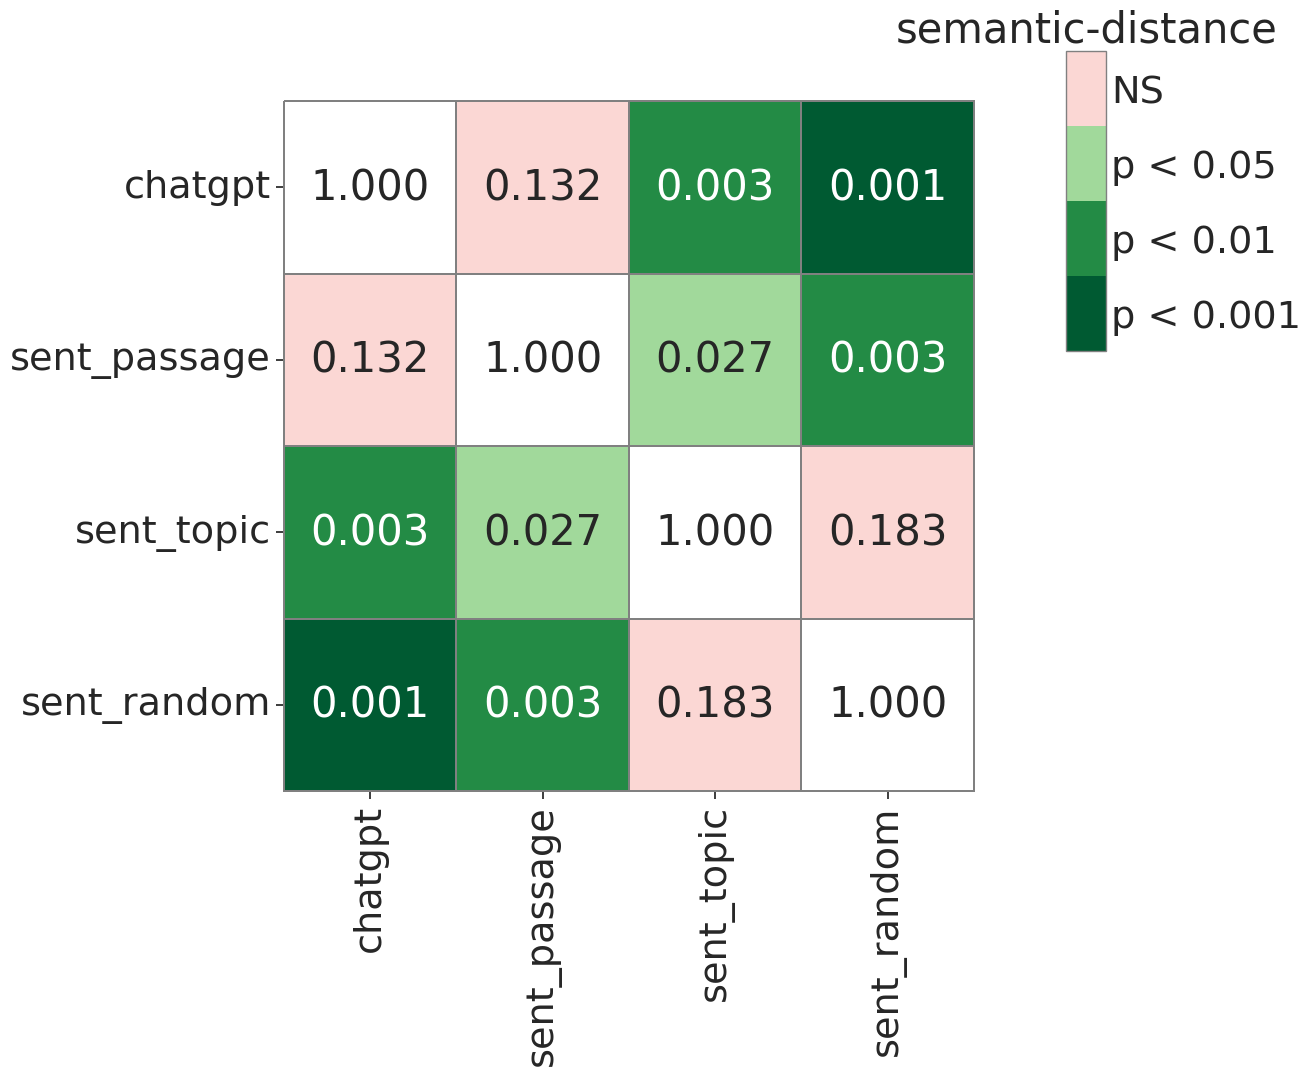

TrainPerturbed-TestPerturbed_decontextualized
word-order
['scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'backward', 'lowpmi', 'lowpmi-random']


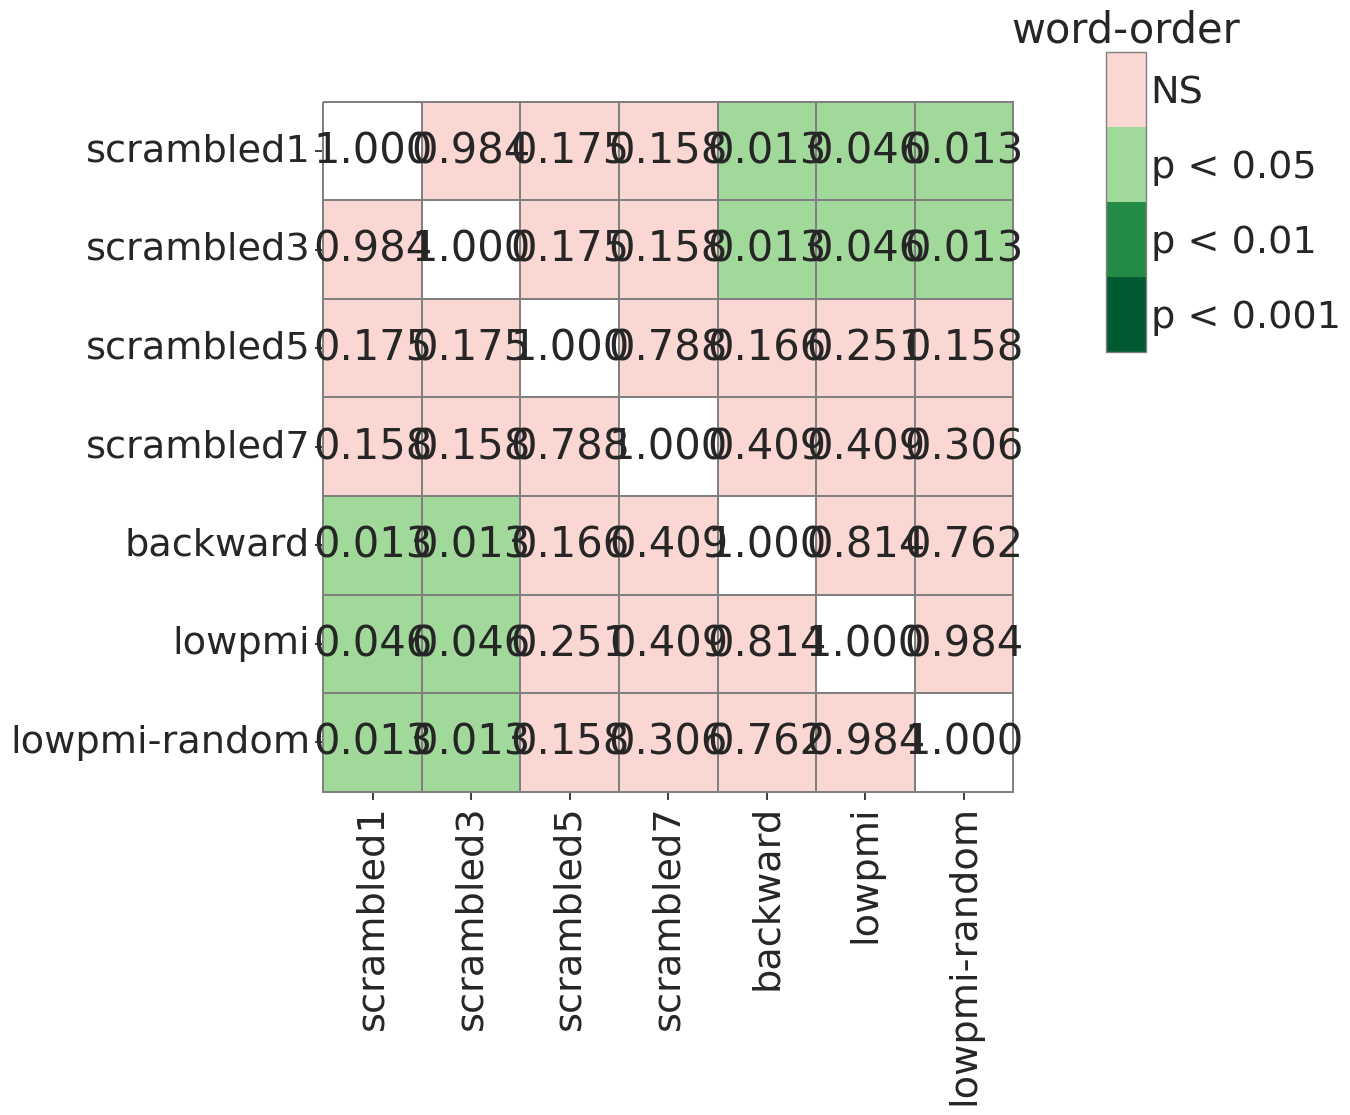

information-loss
['contentwords', 'nounsverbsadj', 'nounsverbs', 'nouns', 'functionwords']


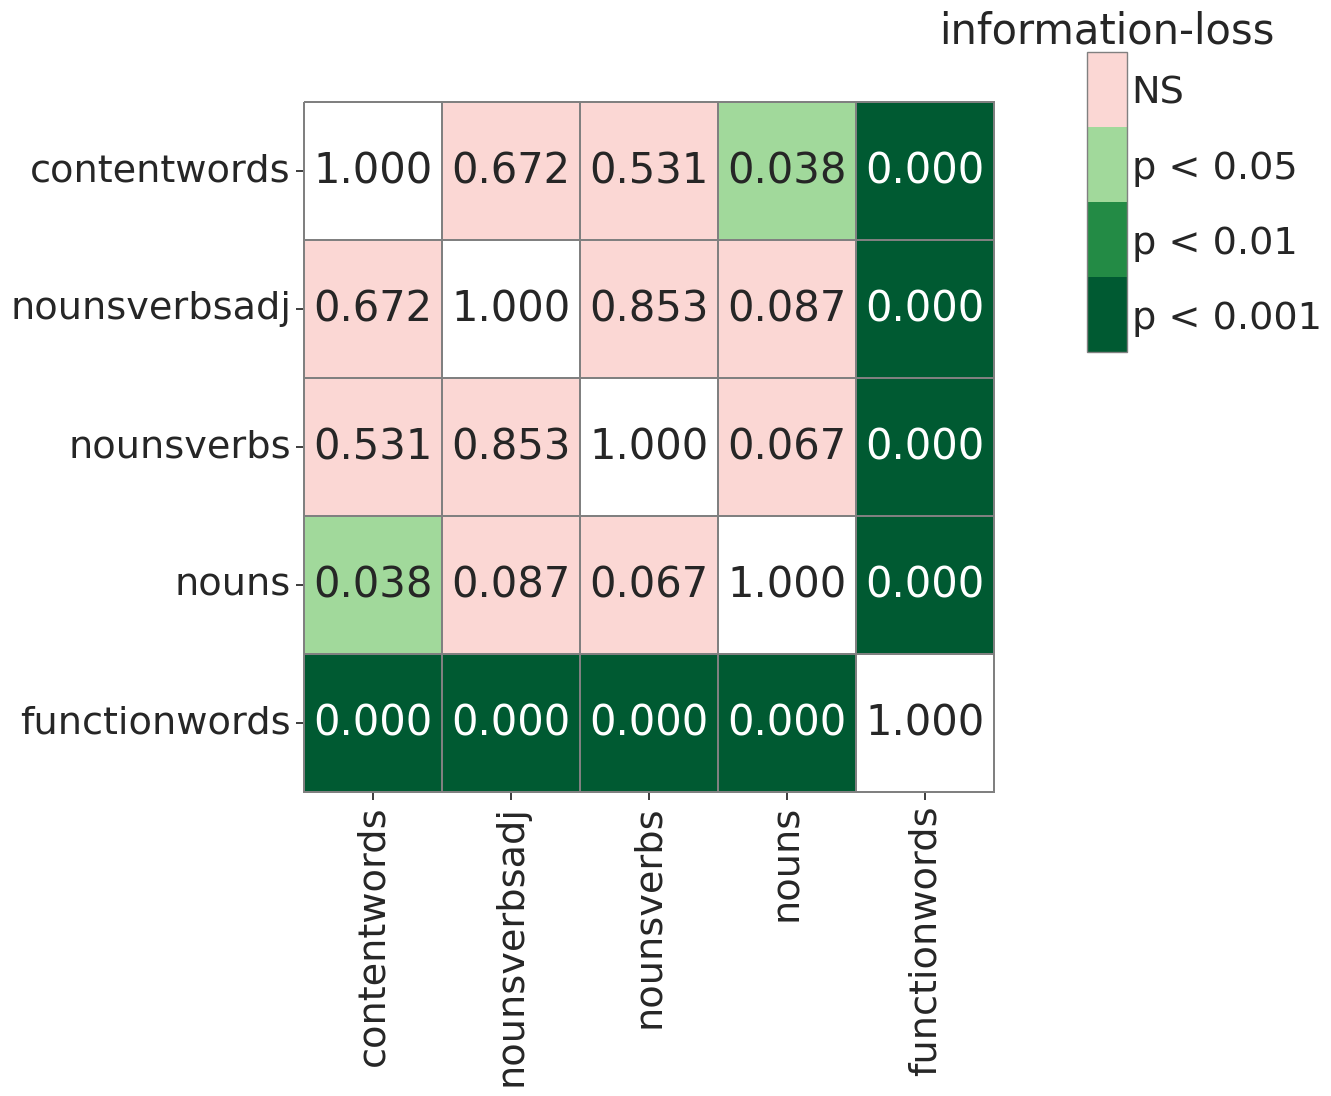

semantic-distance
['chatgpt', 'sent_passage', 'sent_topic', 'sent_random']


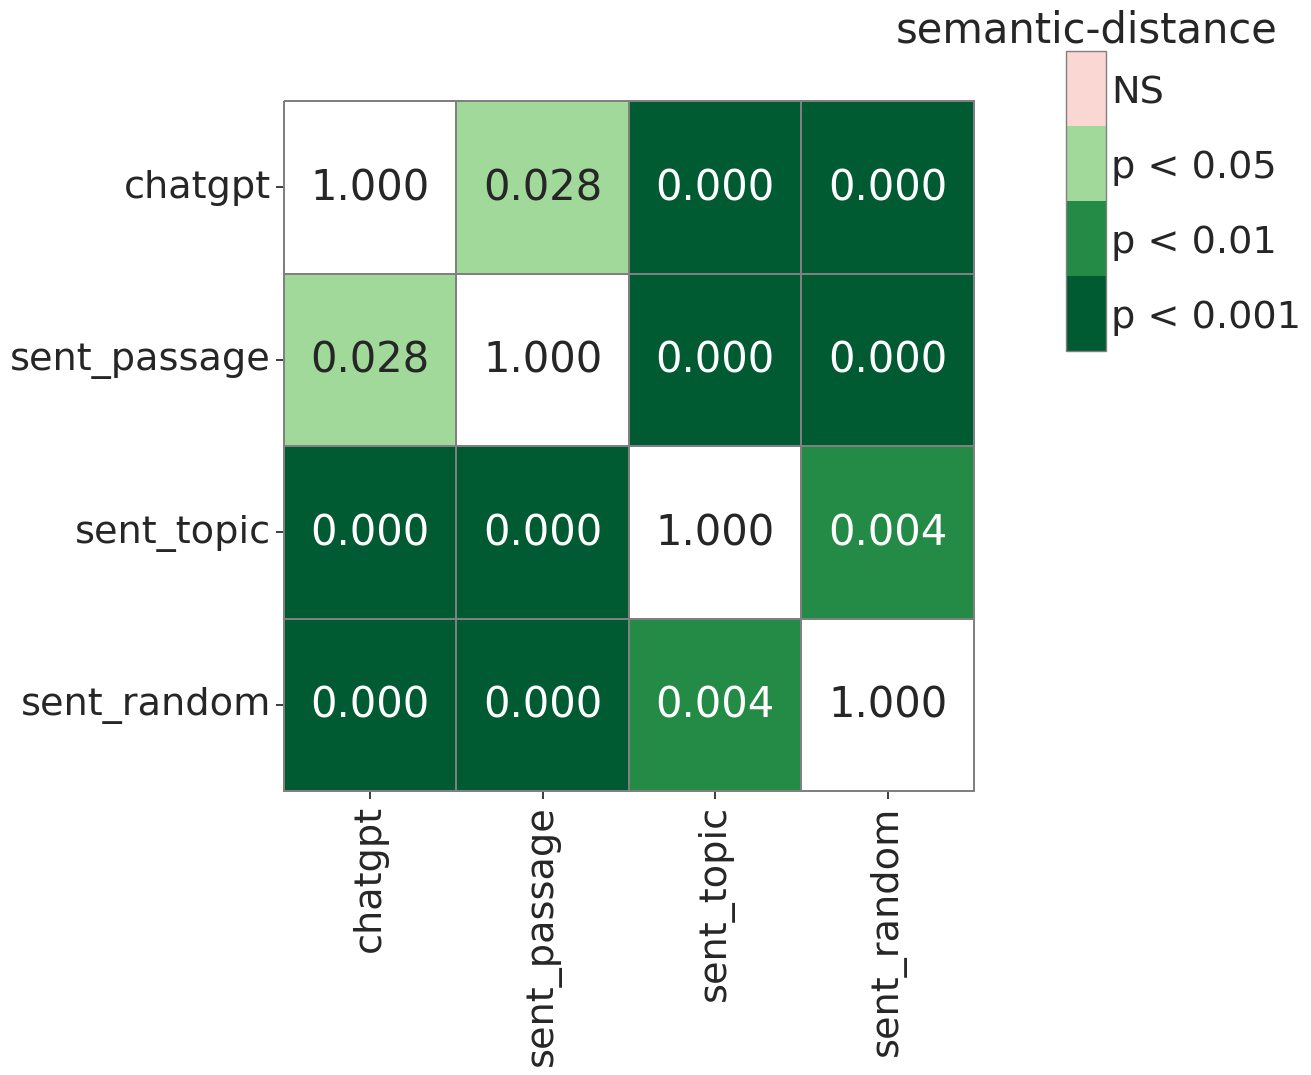

In [30]:
import scikit_posthocs as sp

score_conditions = full_stats_df["score_conditions"].unique()

CAT2COND["semantic-distance"] = ['chatgpt', 'sent_passage', 'sent_topic', 'sent_random']

for sc in score_conditions:
    print(sc)
    sub_df = full_stats_df.loc[full_stats_df["score_conditions"] == sc]
    for category in [x for x in categories if x not in ["original", "control"]]:
        print(category)
        
        print(CAT2COND[category])
        curr_df = sub_df[sub_df["condition"].isin(CAT2COND[category])]
        
        ttest = sp.posthoc_ttest(curr_df, val_col='values', group_col='condition', p_adjust='fdr_bh')

        plt.figure(figsize=(10,10))
        sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
        plt.subplots_adjust(top=0.8) 
        plt.title(f'{category}')

        ttest_df = pd.DataFrame(ttest)
        ttest_df["manipulation"] = [f"{category}"] * len(ttest_df)

        plt.show()